In [ ]:
from pprint import PrettyPrinter

import pandas as pd
import plotly.express as px
from country_converter import CountryConverter

In [ ]:
pp = PrettyPrinter(indent=2)
client = MongoClient(host="localhost",port=27017)

In [ ]:
pp.pprint(list(client.list_databases()))



```
[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 4190208},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 12288},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728},
  {'empty': False, 'name': 'wqu-abtest', 'sizeOnDisk': 585728}]
```



Assign the "ds-applicants" collection in the "wqu-abtest" database to the variable name ds_app.

In [ ]:
db = client["wqu-abtest"]
ds_app = db["ds-applicants"]

In [ ]:
# Count documents in `ds_app`
n_documents = ds_app.count_documents({})
print("Num. documents in 'ds-applicants':", n_documents)

Num. documents in 'ds-applicants': 5025

In [ ]:
result = ds_app.find_one({})
print("result type:", type(result))
pp.pprint(result)



```
result type: <class 'dict'>
{ '_id': ObjectId('6525d787953844722c8383f8'),
  'admissionsQuiz': 'incomplete',
  'birthday': datetime.datetime(1998, 4, 29, 0, 0),
  'countryISO2': 'GB',
  'createdAt': datetime.datetime(2022, 5, 13, 15, 2, 44),
  'email': 'terry.hassler28@yahow.com',
  'firstName': 'Terry',
  'gender': 'male',
  'highestDegreeEarned': "Bachelor's degree",
  'lastName': 'Hassler'}
```



## Nationality

In [ ]:
result = ds_app.aggregate(
    [
        {
            "$group": {
                "_id":"$countryISO2", "count": {"$count": {}}
            }
        }
    ]
)
print("result type:", type(result))

result type: <class 'pymongo.command_cursor.CommandCursor'>

In [ ]:
df_nationality = pd.DataFrame(result).rename({"_id":"country_iso2"}, axis="columns").sort_values("count")

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()



```
df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (139, 2)
     _id	count
0	BW	20
1	GM	22
2	BR	16
3	AD	1
4	US	97
```

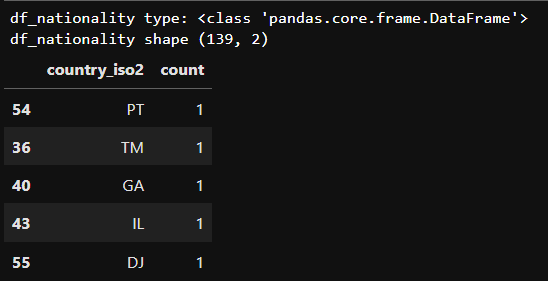

Now we have the countries, but they're represented using the ISO 3166-1 alpha-2 standard, where each country has a two-letter code. It'll be much easier to interpret our data if we have the full country name, so we'll need to do some data enrichment using country converter library.



In [ ]:
cc = CountryConverter()
df_nationality["country_name"] = cc.convert(
    df_nationality["country_iso2"], to="name_short"
)

print("df_nationality shape:", df_nationality.shape)
df_nationality.tail()

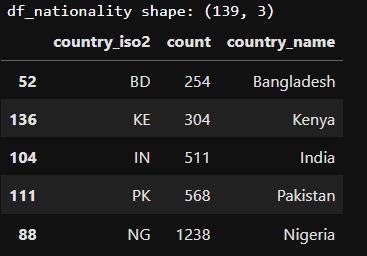

In [ ]:
# Create horizontal bar chart
fig = px.bar(
    data_frame=df_nationality.tail(10),
    x="count",
    y="country_name",
    orientation="h",
    title="DS Applicants by Country"
)
# Set axis labels
fig.update_layout(xaxis_title="Frequency [count]",yaxis_title="Country")
fig.show()

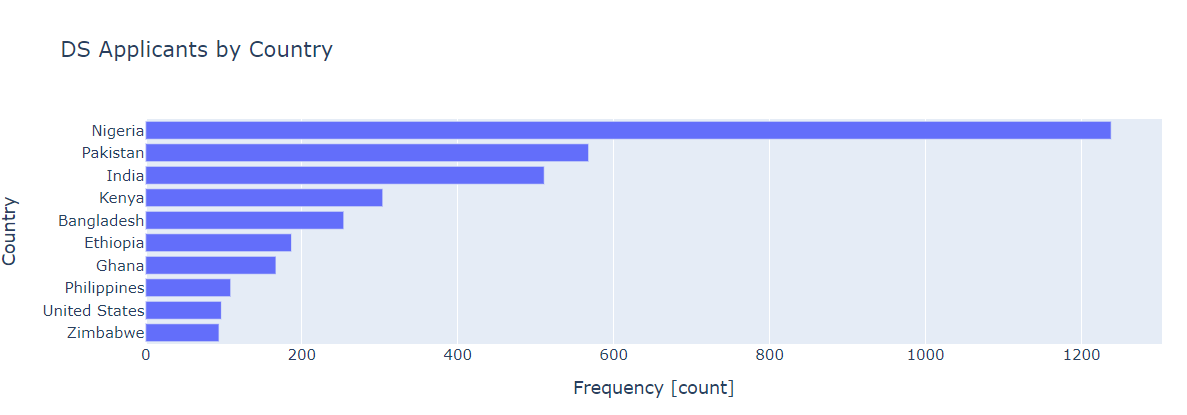

In [ ]:
df_nationality["count_pct"] = (df_nationality["count"] / df_nationality["count"].sum()) * 100

print("df_nationality shape:", df_nationality.shape)
df_nationality.head()

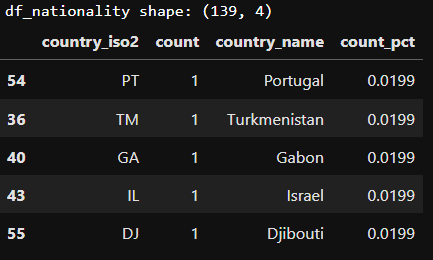

In [ ]:
# Create horizontal bar chart
fig = px.bar(
    data_frame=df_nationality.tail(10),
    x="count_pct",
    y="country_name",
    orientation="h",
    title="DS Applicants by Country"
)
# Set axis labels
fig.update_layout(xaxis_title="Frequency [%]",yaxis_title="Country")
fig.show()

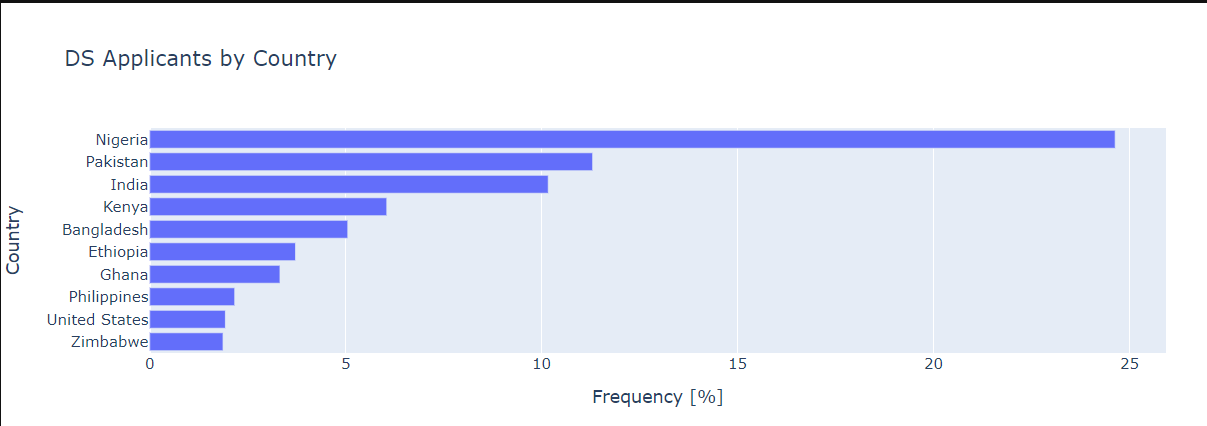

In [ ]:
df_nationality["country_iso3"] = cc.convert(df_nationality["country_iso2"], to="ISO3")

print("df_nationality shape:", df_nationality.shape)
df_nationality.head()

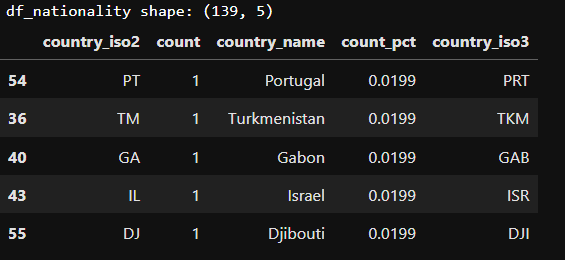

In [ ]:
def build_nat_choropleth():
    fig = px.choropleth(
        data_frame=df_nationality,
        locations="country_iso3",
        color="count_pct",
        projection="natural earth",
        color_continuous_scale=px.colors.sequential.Oranges,
        title="DS Applicants by Country"
    )
    return fig


nat_fig = build_nat_choropleth()
nat_fig.show()

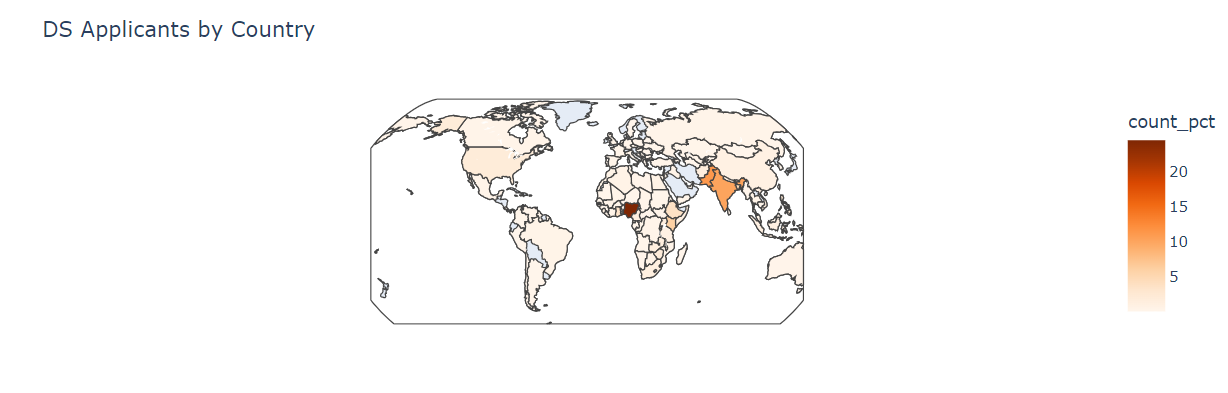

## Age

In [ ]:
result = ds_app.aggregate(
    [
        {
            "$project": {
                "years": {
                    "$dateDiff": {
                        "startDate": "$birthday",
                        "endDate": "$$NOW",
                        "unit": "year"
                    }
                }
            }
        }
    ]
)

ages = pd.DataFrame(result)["years"]

In [ ]:
def build_age_hist():
    # Create histogram of `ages`
    fig = px.histogram(x=ages, nbins=20, title="Distribution of DS Applicant Ages")
    # Set axis labels
    fig.update_layout(xaxis_title="Age",yaxis_title="Frequency [count]")
    return fig


age_fig = build_age_hist()
age_fig.show()

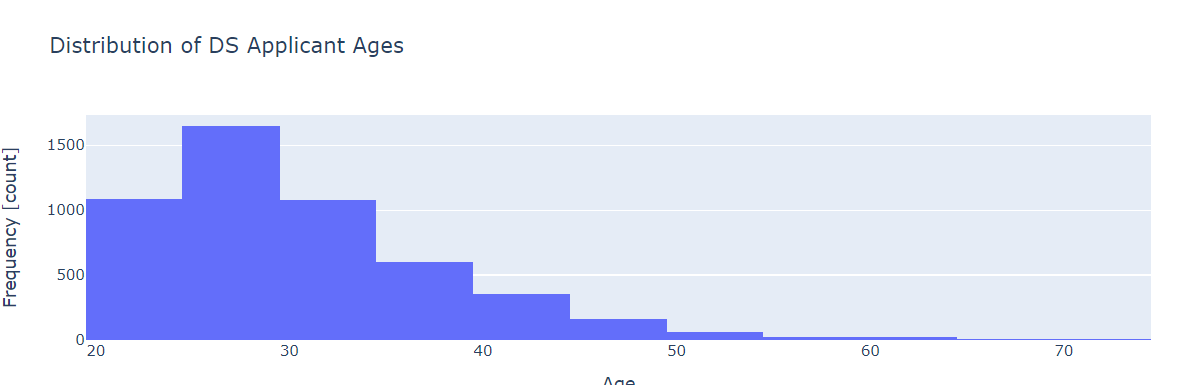

## Education

In [ ]:
result = ds_app.aggregate(
    [
        {
            "$group": {
                "_id":"$highestDegreeEarned", "count": {"$count": {}}
            }
        }
    ]
)

In [ ]:
education = (
    pd.DataFrame(result)
    .rename({"_id": "highest_degree_earned"}, axis="columns")
    .set_index("highest_degree_earned")
    .squeeze() #if it's a df with 1 column, it turns it into a series
)
print("education type:", type(education))
print("education shape:", education.shape)
education.head()



```
education type: <class 'pandas.core.series.Series'>
education shape: (5,)
highest_degree_earned
Bachelor's degree               2643
Master's degree                  862
Some College (1-3 years)         612
High School or Baccalaureate     832
Doctorate (e.g. PhD)              76
Name: count, dtype: int64
```



In [ ]:
def ed_sort(counts):
    """Sort array `counts` from highest to lowest degree earned."""
    degrees = [
        "High School or Baccalaureate",
        "Some College (1-3 years)",
        "Bachelor's degree",
        "Master's degree",
        "Doctorate (e.g. PhD)",
    ]
    mapping = {k: v for v,k in enumerate(degrees)}
    sort_order = [mapping[c] for c in counts]
    return sort_order


education.sort_index(key=ed_sort, inplace=True)
education



```
highest_degree_earned
High School or Baccalaureate     832
Some College (1-3 years)         612
Bachelor's degree               2643
Master's degree                  862
Doctorate (e.g. PhD)              76
Name: count, dtype: int64
```



In [ ]:
def build_ed_bar():
    # Create bar chart
    fig = px.bar(
        x=education,
        y=education.index,
        orientation="h",
        title="DS Applicant Education Levels"
    )
    # Add axis labels
    fig.update_layout(xaxis_title="Frequency [count]",yaxis_title="Degree")
    return fig


ed_fig = build_ed_bar()
ed_fig.show()

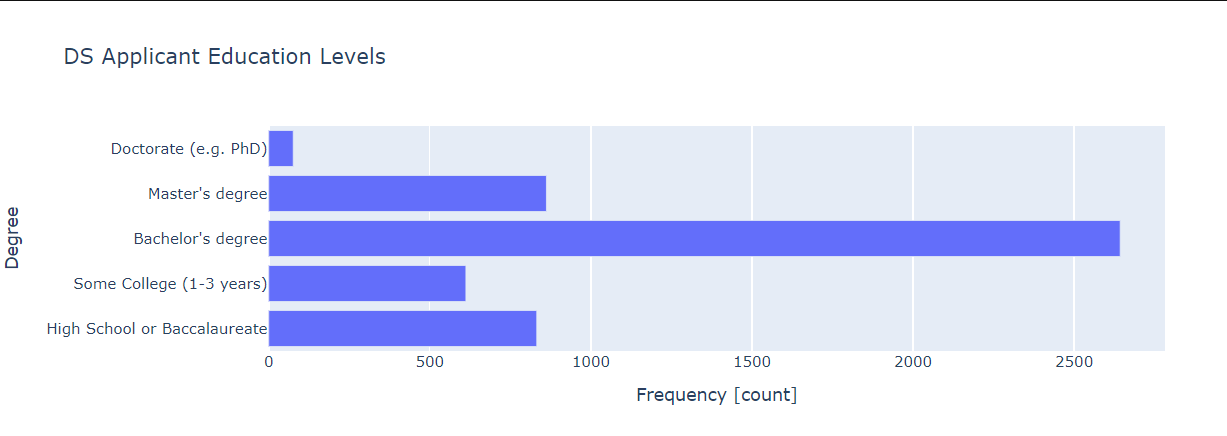

# Extract: Developing the Hypothesis

In [ ]:
# How many applicants complete admissions quiz?
result = ds_app.aggregate(
    [
        {
            "$group":{
                "_id": "$admissionsQuiz",
                "count": {"$count":{}}
            }
        }
    ]
)

for r in result:
    if r["_id"] == "incomplete":
        incomplete = r["count"]
    else:
        complete = r["count"]


print("Completed quiz:", complete)
print("Did not complete quiz:", incomplete)

Completed quiz: 3717

Did not complete quiz: 1308

In [ ]:
total = complete + incomplete
prop_incomplete = incomplete / total
print(
    "Proportion of users who don't complete admissions quiz:", round(prop_incomplete, 2)
)

Proportion of users who don't complete admissions quiz: 0.26

In [ ]:
null_hypothesis = """
    There is no relationship between receiving and email and completing the admission quiz.
    Sending an email to 'no-quiz applicants' does not increase the rate of completion.
"""

alternate_hypothesis = """
    There is a relationship between receiving and email and completing the admission quiz.
    Sending an email to 'no-quiz applicants' does increase the rate of completion.
"""

print("Null Hypothesis:", null_hypothesis)
print("Alternate Hypothesis:", alternate_hypothesis)

Null Hypothesis: 
    There is no relationship between receiving and email and completing the admission quiz.
    Sending an email to 'no-quiz applicants' does not increase the rate of completion.

Alternate Hypothesis: 
    There is a relationship between receiving and email and completing the admission quiz.
    Sending an email to 'no-quiz applicants' does increase the rate of completion.



In [ ]:
def find_by_date(collection, date_string):
    """Find records in a PyMongo Collection created on a given date.

    Parameters
    ----------
    collection : pymongo.collection.Collection
        Collection in which to search for documents.
    date_string : str
        Date to query. Format must be '%Y-%m-%d', e.g. '2022-06-28'.

    Returns
    -------
    observations : list
        Result of query. List of documents (dictionaries).
    """
    # Convert `date_string` to datetime object
    start = pd.to_datetime(date_string, format="%Y-%m-%d")
    # Offset `start` by 1 day
    end = start + pd.DateOffset(days=1)
    # Create PyMongo query for no-quiz applicants between`start` and `end`
    query = {"createdAt": {"$gte": start, "$lt": end}, "admissionsQuiz": "incomplete"}
    # Query collection, get result
    result = collection.find(query)
    # Convert `result` to list
    observations = list(result)

    return observations

In [ ]:
observations = find_by_date(ds_app, date_string="2022-05-05")

print("observations type:", type(observations))
print("observations len:", len(observations))
observations[0]



```
observations type: <class 'list'>
observations len: 47
{'_id': ObjectId('65c53874b201df2570ded175'),
 'createdAt': datetime.datetime(2022, 5, 5, 18, 39, 40),
 'firstName': 'Curtis',
 'lastName': 'Rogers',
 'email': 'curtis.rogers14@microsift.com',
 'birthday': datetime.datetime(1987, 12, 4, 0, 0),
 'gender': 'male',
 'highestDegreeEarned': 'Some College (1-3 years)',
 'countryISO2': 'NG',
 'admissionsQuiz': 'incomplete'}
```



# Transform: Designing the Experiment

In [ ]:
def assign_to_groups(observations):
    """Randomly assigns observations to control and treatment groups.

    Parameters
    ----------
    observations : list or pymongo.cursor.Cursor
        List of users to assign to groups.

    Returns
    -------
    observations : list
        List of documents from `observations` with two additional keys:
        `inExperiment` and `group`.
    """
    # Shuffle `observations`
    random.seed(42)
    random.shuffle(observations)

    # Get index position of item at observations halfway point
    idx = len(observations) // 2

    # Assign first half of observations to control group
    for doc in observations[:idx]:
        doc["inExperiment"] = True
        doc["group"] = "no email (control)"

    # Assign second half of observations to treatment group
    for doc in observations[idx:]:
        doc["inExperiment"] = True
        doc["group"] = "email (treatment)"


    return observations

In [ ]:
observations_assigned = assign_to_groups(observations)

print("observations_assigned type:", type(observations_assigned))
print("observations_assigned len:", len(observations_assigned))
observations_assigned[0]



```
observations_assigned type: <class 'list'>
observations_assigned len: 47
{'_id': ObjectId('65c53874b201df2570dedffd'),
 'createdAt': datetime.datetime(2022, 5, 5, 5, 34, 18),
 'firstName': 'Clay',
 'lastName': 'Howard',
 'email': 'clay.howard21@hotmeal.com',
 'birthday': datetime.datetime(1989, 1, 4, 0, 0),
 'gender': 'male',
 'highestDegreeEarned': 'High School or Baccalaureate',
 'countryISO2': 'NG',
 'admissionsQuiz': 'incomplete',
 'inExperiment': True,
 'group': 'no email (control)'}
```



In [ ]:
def export_treatment_emails(observations_assigned, directory="."):
    """Creates CSV file with email addresses of observations in treatment group.

    CSV file name will include today's date, e.g. `'2022-06-28_ab-test.csv'`,
    and a `'tag'` column where every row will be 'ab-test'.

    Parameters
    ----------
    observations_assigned : list
        Observations with group assignment.
    directory : str, default='.'
        Location for saved CSV file.

    Returns
    -------
    None
    """
    # Put `observations_assigned` docs into DataFrame
    df = pd.DataFrame(observations_assigned)

    # Add `"tag"` column
    df["tag"] = "ab-test"

    # Create mask for treatment group only
    mask = df["group"] == "email (treatment)"

    # Create filename with date
    date_string = pd.Timestamp.now().strftime(format="%Y-%m-%d")
    filename = directory + "/" + date_string + "_ab-test.csv"

    # Save DataFrame to directory (email and tag only)
    df[mask][["email", "tag"]].to_csv(filename, index=False)

In [ ]:
export_treatment_emails(observations_assigned=observations_assigned)

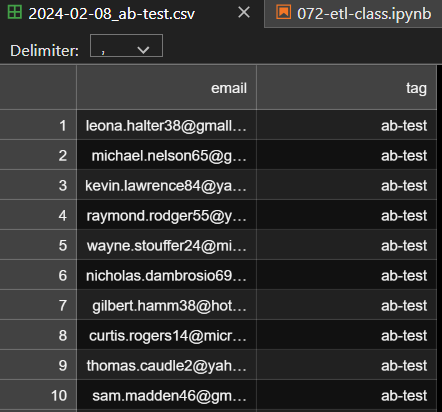

# Load: Preparing the Data

In [ ]:
updated_applicant = observations_assigned[0]
applicant_id = updated_applicant["_id"]

print("applicant type:", type(updated_applicant))
print(updated_applicant)
print()
print("applicant_id type:", type(applicant_id))
print(applicant_id)



```
applicant type: <class 'dict'>
{'_id': ObjectId('65c53874b201df2570dedffd'), 'createdAt': datetime.datetime(2022, 5, 5, 5, 34, 18), 'firstName': 'Clay', 'lastName': 'Howard', 'email': 'clay.howard21@hotmeal.com', 'birthday': datetime.datetime(1989, 1, 4, 0, 0), 'gender': 'male', 'highestDegreeEarned': 'High School or Baccalaureate', 'countryISO2': 'NG', 'admissionsQuiz': 'incomplete', 'inExperiment': True, 'group': 'no email (control)'}

applicant_id type: <class 'bson.objectid.ObjectId'>
65c53874b201df2570dedffd
```



In [ ]:
# Find original record for `applicant_id`
ds_app.find_one({"_id": applicant_id})



```
{'_id': ObjectId('65c53874b201df2570dedffd'),
 'createdAt': datetime.datetime(2022, 5, 5, 5, 34, 18),
 'firstName': 'Clay',
 'lastName': 'Howard',
 'email': 'clay.howard21@hotmeal.com',
 'birthday': datetime.datetime(1989, 1, 4, 0, 0),
 'gender': 'male',
 'highestDegreeEarned': 'High School or Baccalaureate',
 'countryISO2': 'NG',
 'admissionsQuiz': 'incomplete'}
```



In [ ]:
result = ds_app.update_one(
    filter={"_id": applicant_id},
    update={"$set": updated_applicant}
)

print("result type:", type(result))

result type: <class 'pymongo.results.UpdateResult'>

In [ ]:
def update_applicants(collection, observations_assigned):
    """Update applicant documents in collection.

    Parameters
    ----------
    collection : pymongo.collection.Collection
        Collection in which documents will be updated.

    observations_assigned : list
        Documents that will be used to update collection

    Returns
    -------
    transaction_result : dict
        Status of update operation, including number of documents
        and number of documents modified.
    """
    # Initialize counters
    n=0
    n_modified=0

    # Iterate through applicants
    for doc in observations_assigned:
        # Update doc
        result = collection.update_one(
            filter={"_id": doc["_id"]},
            update={"$set": doc}
        )
        # Update counters
        n += result.matched_count
        n_modified += result.modified_count

    # Create results
    transaction_result = {"n": n, "nModified": n_modified}

    return transaction_result

In [ ]:
result = update_applicants(ds_app, observations_assigned)
print("result type:", type(result))
result

result type: <class 'dict'>

{'n': 47, 'nModified': 0}

# Python Classes: Building the Repository

In [ ]:
class MongoRepository:
    """Repository class for interacting with MongoDB database.

    Parameters
    ----------
    client : `pymongo.MongoClient`
        By default, `MongoClient(host='localhost', port=27017)`.
    db : str
        By default, `'wqu-abtest'`.
    collection : str
        By default, `'ds-applicants'`.

    Attributes
    ----------
    collection : pymongo.collection.Collection
        All data will be extracted from and loaded to this collection.
    """

    # Task 7.2.14

    def __init__(self, client=MongoClient(host="localhost",port=27017), db="wqu-abtest", collection="ds-applicants"):
        self.collection = client[db][collection]

    # Task 7.2.17

    def find_by_date(self, date_string):
      # Convert `date_string` to datetime object
      start = pd.to_datetime(date_string, format="%Y-%m-%d")
      # Offset `start` by 1 day
      end = start + pd.DateOffset(days=1)
      # Create PyMongo query for no-quiz applicants between`start` and `end`
      query = {"createdAt": {"$gte": start, "$lt": end}, "admissionsQuiz": "incomplete"}
      # Query collection, get result
      result = self.collection.find(query)
      # Convert `result` to list
      observations = list(result)

      return observations

    # Task 7.2.18

    def update_applicants(self, observations_assigned):
      # Initialize counters
      n=0
      n_modified=0

      # Iterate through applicants
      for doc in observations_assigned:
          # Update doc
          result = self.collection.update_one(
              filter={"_id": doc["_id"]},
              update={"$set": doc}
          )
          # Update counters
          n += result.matched_count
          n_modified += result.modified_count

      # Create results
      transaction_result = {"n": n, "nModified": n_modified}

      return transaction_result

    # Task 7.2.19

    def assign_to_groups(self, date_string):
      # Get observations
      observations = self.find_by_date(date_string)

      # Shuffle `observations`
      random.seed(42)
      random.shuffle(observations)

      # Get index position of item at observations halfway point
      idx = len(observations) // 2

      # Assign first half of observations to control group
      for doc in observations[:idx]:
          doc["inExperiment"] = True
          doc["group"] = "no email (control)"

      # Assign second half of observations to treatment group
      for doc in observations[idx:]:
          doc["inExperiment"] = True
          doc["group"] = "email (treatment)"

      # Update colelction
      result = self.update_applicants(observations)

      return result

In [ ]:
repo = MongoRepository()
print("repo type:", type(repo))
repo

repo type: <class '__main__.MongoRepository'>

<__main__.MongoRepository at 0x7f0079e71550>

In [ ]:
c_test = repo.collection
print("c_test type:", type(c_test))
c_test

c_test type: <class 'pymongo.collection.Collection'>

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'wqu-abtest'), 'ds-applicants')

In [ ]:
may_15_users = repo.find_by_date(date_string="2022-05-15")
print("may_15_users type", type(may_15_users))
print("may_15_users len", len(may_15_users))
may_15_users[:3]



```
may_15_users type <class 'list'>
may_15_users len 30
[{'_id': ObjectId('65c53874b201df2570ded214'),
  'createdAt': datetime.datetime(2022, 5, 15, 20, 21, 12),
  'firstName': 'Patrick',
  'lastName': 'Derosa',
  'email': 'patrick.derosa81@hotmeal.com',
  'birthday': datetime.datetime(2000, 9, 30, 0, 0),
  'gender': 'male',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'UA',
  'admissionsQuiz': 'incomplete'},
 {'_id': ObjectId('65c53874b201df2570ded333'),
  'createdAt': datetime.datetime(2022, 5, 15, 10, 50, 56),
  'firstName': 'Deidre',
  'lastName': 'Pagan',
  'email': 'deidre.pagan75@hotmeal.com',
  'birthday': datetime.datetime(1996, 12, 2, 0, 0),
  'gender': 'female',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'ZW',
  'admissionsQuiz': 'incomplete'},
 {'_id': ObjectId('65c53874b201df2570ded3c6'),
  'createdAt': datetime.datetime(2022, 5, 15, 5, 8, 35),
  'firstName': 'Harry',
  'lastName': 'Ellis',
  'email': 'harry.ellis78@microsift.com',
  'birthday': datetime.datetime(2000, 2, 6, 0, 0),
  'gender': 'male',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'CM',
  'admissionsQuiz': 'incomplete'}]
```



In [ ]:
result = repo.update_applicants(observations_assigned)
print("result type:", type(result))
result

result type: <class 'dict'>

{'n': 47, 'nModified': 0}



In [ ]:
result = repo.assign_to_groups(date_string="2022-05-15")
print("result type:", type(result))
result

result type: <class 'dict'>

{'n': 30, 'nModified': 30}

# **Chi-square test**

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from pymongo import MongoClient
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

# Preparing the Experiment

In [ ]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.2, alpha=0.05, power=0.8))

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 197

Total # of applicants needed: 394


---



The results here are telling us that if we want to detect an effect size of 0.2 we need a group size of about 200 people. Since our experiment has two conditions (treatment and control, or email and no email), that means we need a total of about 400 applicants in our experiment.

But what about detecting other effect sizes? If we needed to detect a larger effect size, we'd need fewer applicants. If we needed to detect a smaller effect size, we'd need more applicants. One way to visualize the relationship between effect size, statistical power, and number of applicants is to make a graph.

In [ ]:
n_observations = np.arange(0, group_size * 2 +1)
effect_sizes = np.array([0.2, 0.5, 0.8])

# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effect_sizes,
    alpha=0.05,
    n_bins=2
);

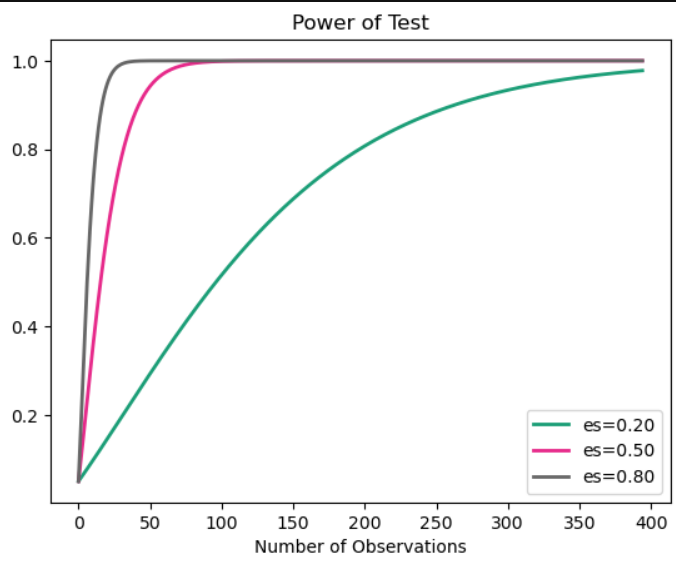

We calculate how many new accounts were created each day included in the database.

We have the date with year,month,day and hours. But to group by day, we need to truncate the date to day and ignore the hour.

In [ ]:
result = ds_app.aggregate(
    [
        {"$match": {"admissionsQuiz": "incomplete"}},
        {
            "$group":{
                "_id": {"$dateTrunc": {"date": "$createdAt", "unit": "day"}},
                "count": {"$sum":1}
            }
        }
    ]
)


In [ ]:
# Create histogram of `no_quiz`
no_quiz.hist()
# Add axis labels and title
plt.xlabel("New Users with No Quiz")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily New Users with No Quiz");

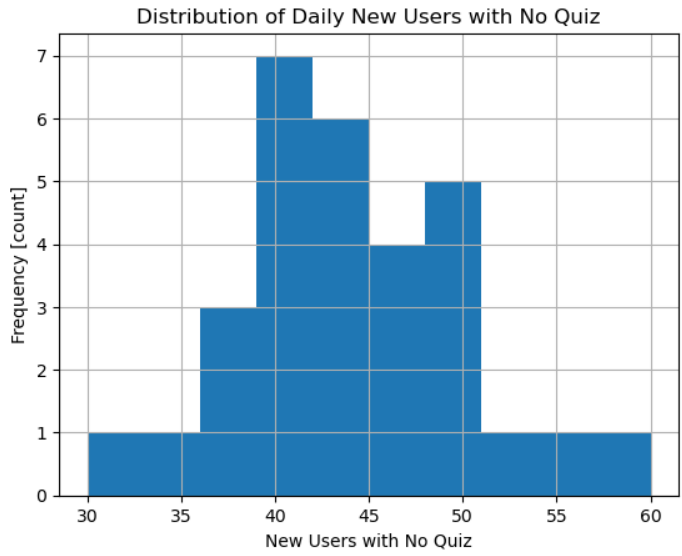

In [ ]:
mean = no_quiz.mean()
std = no_quiz.std()
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 43.6

no_quiz std: 6.398275629767974



---
Calculate the mean and standard deviation of the probability distribution for the total number of sign-ups over 10 days.


In [ ]:
days = 10
sum_mean = mean * days
sum_std = std * math.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 436.0

Std of sum: 20.233124087615032



---
With this new distribution, we want to know what the probability is that we'll have 400 or more no-quiz applicants after 10 days. We can calculate this using the **cumulative density function** or CDF. The CDF will give us the probability of having 400 or fewer no-quiz applicants, so we'll need to subtract our result from 1.


In [ ]:
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    loc=sum_mean,
    scale=sum_std
)
prob_400_or_greater = 1 - prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Probability of getting 400+ no_quiz in 10 days: 0.981

# Running the Experiment

In [ ]:
# Instantiate Experiment
exp = Experiment(repo=client, db="wqu-abtest", collection="ds-applicants")
exp.reset_experiment()

# Run Experiment
result = exp.run_experiment(days=days)
print("result type:", type(result))
result

result type: <class 'dict'>

{'acknowledged': True, 'inserted_count': 1590}

# Evaluating Experiment Results


In [ ]:
result = ds_app.find({"inExperiment": True})

In [ ]:
df = pd.DataFrame(result).dropna()

print("df type:", type(df))
print("df shape:", df.shape)

df type: <class 'pandas.core.frame.DataFrame'>

df shape: (457, 12)

In [ ]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

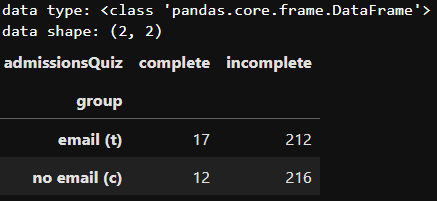

In [ ]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(data_frame=data, barmode="group", title="Admissions Quiz Completion by Group")
    # Set axis labels
    fig.update_layout(xaxis_title="Group", yaxis_title="Frequency [count]", legend={"title":"Admissions Quiz"})
    return fig

In [ ]:
build_contingency_bar().show()

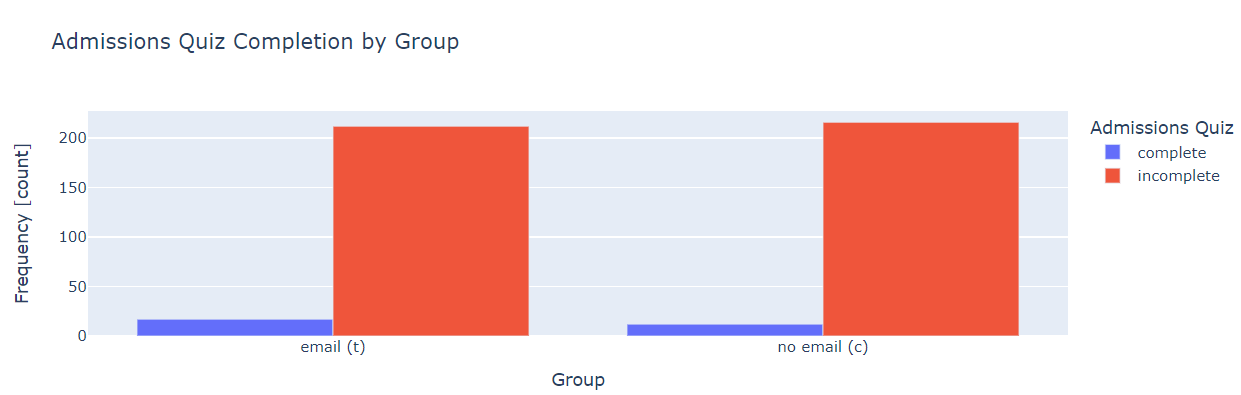

Without doing anything else, we can see that people who got an email actually did complete the quiz more often than people who didn't. So can we conclude that, as a general rule, applicants who receive an email are more likely to complete quiz. No, not yet. After all, the difference we see could be due to chance.

In order to determine if this difference is more than random variation, we need to take our results, put them into a **contingency table**, and run a statistical test.

In [ ]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig





```
contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>
array( [ [ 17, 212] ,
       [ 12, 216] ])
```





---
Now that we have our table, we can calculate what we would expect to see if there was no difference quiz completion between our two groups.


In [ ]:
# Calculate fitted values
contingency_table.fittedvalues.round(3)



```
array([[ 14.532, 214.468],
       [ 14.468, 213.532]])
```



In [ ]:
# Calculate independent joint probabilities
contingency_table.independence_probabilities.round(3)



```
array([[0.032, 0.469],
       [0.032, 0.467]])
```



## Conduct Chi-Square Test

In [ ]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)



```
chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.3435152497895756
statistic   0.8972682555334336
```



The important part of that result is the p-value. We set our threshold for significance at 0.05 way back at the beginning, so, for our results to be statistically significant, the p-value needs to be less than or equal to 0.05. Our p-value is much higher than 0.05, which means that the difference we saw in our side-by-side bar graph is probably due to chance. In other words, it's noise, not signal. So we can't reject our null hypothesis.

What does this result mean? It means there may not be any difference between the groups, or that the difference is so small that we don't have the statistical power to detect it.


However, there are two important things to keep in mind. First, just because a result is statistically significant doesn't mean that it's practically significant. A 1% increase in quiz completion may not be worth the time or resources needed to run an email campaign every day. Second, when the number of observations gets very large, any small difference is going to appear statistically significant. This increases the risk of a false positive — rejecting our null hypothesis when it's actually true.

In [ ]:
odds_ratio = contingency_table.oddsratio.round(1)
print("Odds ratio:", odds_ratio)

Odds ratio: 1.4

The interpretation here is that for every 1 person who doesn't complete the quiz, about 1.4 people do. Keep in mind, though, that this ratio isn't actionable in the case of our experiment because our results weren't statistically significant.

In [ ]:
summary = contingency_table.summary()
print("summary type:", type(summary))
summary

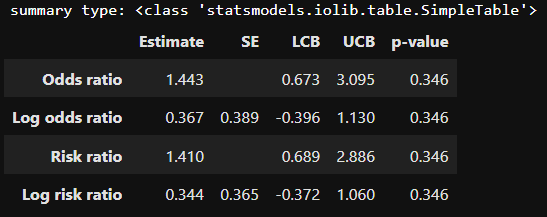

<font size="+3"><strong> Experiment Web Application</strong></font>

We're going to build our application using a three-tier architecture. The three `.py` files — or **modules** — represent the three layers of our application. We'll start with our display layer, where we'll keep all the elements that our user will see and interact with.

## display.py 👇

In [ ]:
from business import GraphBuilder, StatsBuilder
from dash import Input, Output, State, dcc, html
from jupyter_dash import JupyterDash

# Task 7.4.1
app = JupyterDash(__name__)
# Task 7.4.8
gb = GraphBuilder()
# Task 7.4.13
sb = StatsBuilder()

# Tasks 7.4.1, 7.4.2, 7.4.3, 7.4.11, 7.4.14, 7.4.16
app.layout = html.Div(
    [
        html.H1("Application Demographics"),
        dcc.Dropdown(
            options=["Nationality", "Age", "Education"],
            value="Nationality",
            id="demo-plots-dropdown"
        ),
        html.Div(id="demo-plots-display"),
        html.H1("Experiment"),
        html.H2("Choose your effect size"),
        dcc.Slider(min=0.1, max=0.8, step=0.1, value=0.2, id="effect-size-slider"),
        html.Div(id="effect-size-display"),
        html.H2("Choose experiment duration"),
        dcc.Slider(min=1, max=20, step=1, value=1, id="experiment-days-slider"),
        html.Div(id="experiment-days-display"),
        html.H1("Results"),
        html.Button("Begin Experiment", id="start-experiment-button", n_clicks=0),
        html.Div(id="results-display")
    ]
)

# Tasks 7.4.4, 7.4.8, 7.4.9, 7.4.10
@app.callback(
    Output("demo-plots-display", "children"),
    Input("demo-plots-dropdown", "value")
)
def display_demo_graph(graph_name):
    """Serves applicant demograhic visualization.

    Parameters
    ----------
    graph_name : str
        User input given via 'demo-plots-dropdown'. Name of Graph to be returned.
        Options are 'Nationality', 'Age', 'Education'.

    Returns
    -------
    dcc.Graph
        Plot that will be displayed in 'demo-plots-display' Div.
    """
    if graph_name == "Nationality":
        fig = gb.build_nat_choropleth()
    elif graph_name == "Age":
        fig = gb.build_age_hist()
    else:
        fig = gb.build_ed_bar()
    return dcc.Graph(figure=fig)


# Task 7.4.13
@app.callback(
    Output("effect-size-display", "children"),
    Input("effect-size-slider", "value")
)
def display_group_size(effect_size):
    """Serves information about required group size.

    Parameters
    ----------
    effect_size : float
        Size of effect that user wants to detect. Provided via 'effect-size-slider'.

    Returns
    -------
    html.Div
        Text with information about required group size. will be displayed in
        'effect-size-display'.
    """
    n_obs = sb.calculate_n_obs(effect_size)
    text = f"To detect an effect size of {effect_size}, you will need {n_obs} observations."
    return html.Div(text)



# Task 7.4.15
@app.callback(
    Output("experiment-days-display", "children"),
    Input("effect-size-slider", "value"),
    Input("experiment-days-slider", "value")
)
def display_cdf_pct(effect_size, days):
    """Serves probability of getting desired number of obervations.

    Parameters
    ----------
    effect_size : float
        The effect size that user wants to detect. Provided via 'effect-size-slider'.
    days : int
        Duration of the experiment. Provided via 'experiment-days-slider'.

    Returns
    -------
    html.Div
        Text with information about probabilty. Goes to 'experiment-days-display'.
    """
    # Calculate number of observations
    n_obs = sb.calculate_n_obs(effect_size)
    # Calculate percentage
    pct = round(sb.calculate_cdf_pct(n_obs, days),2)
    # Create text
    text = f"The probability of getting this number of observations in {days} is {pct}%"
    # Return Div with text
    return html.Div(text)


# Task 7.4.17
@app.callback(
    Output("results-display", "children"),
    Input("start-experiment-button", "n_clicks"),
    State("experiment-days-slider", "value")
)
def display_results(n_clicks, days):
    """Serves results from experiment.

    Parameters
    ----------
    n_clicks : int
        Number of times 'start-experiment-button' button has been pressed.
    days : int
        Duration of the experiment. Provided via 'experiment-days-display'.

    Returns
    -------
    html.Div
        Experiment results. Goes to 'results-display'.
    """
    if n_clicks == 0:
        return html.Div()
    else:
        # Run Experiment
        sb.run_experiment(days)
        #Create side-by-side bar chart
        fig = gb.build_contingency_bar()
        # Run chi-square
        result = sb.run_chi_square()
        # Return results
        return html.Div(
            [
                html.H2("Observations"),
                dcc.Graph(figure=fig),
                html.H2("Chi-Square Test for Indenpendance"),
                html.H3(f"Degrees of Freedom: {result.df}"),
                html.H3(f"p-value: {result.pvalue}"),
                html.H3(f"Statistic: {result.statistic}")
            ]
        )

## database.py 👇

In [ ]:
import pandas as pd
from country_converter import CountryConverter
from pymongo import MongoClient


# Tasks 7.4.5, 7.4.6, 7.4.9, 7.4.10
class MongoRepository:
    """For connecting and interacting with MongoDB."""

    def __init__(self, client=MongoClient(host="localhost",port=27017), db="wqu-abtest", collection="ds-applicants"):

        """init

        Parameters
        ----------
        client : pymongo.MongoClient, optional
            By default MongoClient(host="localhost", port=27017)
        db : str, optional
            By default "wqu-abtest"
        collection : str, optional
            By default "ds-applicants"
        """
        self.collection = client[db][collection]

    def get_nationality_value_counts(self, normalize=True):

        """Return nationality value counts.

        Parameters
        ----------
        normalize : bool, optional
            Whether to normalize frequency counts, by default True

        Returns
        -------
        pd.DataFrame
            Database results with columns: 'count', 'country_name', 'country_iso2',
            'country_iso3'.
        """
        # Get result from database
        result = self.collection.aggregate(
            [
                {
                    "$group": {
                        "_id":"$countryISO2", "count": {"$count": {}}
                    }
                }
            ]
        )

        # Store result in DataFrame
        df_nationality = pd.DataFrame(result).rename({"_id":"country_iso2"}, axis="columns").sort_values("count")

        # Add country names and ISO3
        cc = CountryConverter()
        df_nationality["country_name"] = cc.convert(df_nationality["country_iso2"], to="name_short")
        df_nationality["country_iso3"] = cc.convert(df_nationality["country_iso2"], to="ISO3")

        # Transform frequency count to pct
        if normalize:
            df_nationality["count_pct"] = (df_nationality["count"] / df_nationality["count"].sum()) * 100

        # Return DataFrame
        return df_nationality


    def get_ages(self):

        """Gets applicants ages from database.

        Returns
        -------
        pd.Series
        """
        # Get ages from database
        result = self.collection.aggregate(
            [
                {
                    "$project": {
                        "years": {
                            "$dateDiff": {
                                "startDate": "$birthday",
                                "endDate": "$$NOW",
                                "unit": "year"
                            }
                        }
                    }
                }
            ]
        )
        # Load results into series
        ages = pd.DataFrame(result)["years"]
        # Return ages
        return ages


    def __ed_sort(self, counts):

        """Helper function for self.get_ed_value_counts."""

        degrees = [
            "High School or Baccalaureate",
            "Some College (1-3 years)",
            "Bachelor's degree",
            "Master's degree",
            "Doctorate (e.g. PhD)",
        ]
        mapping = {k: v for v,k in enumerate(degrees)}
        sort_order = [mapping[c] for c in counts]
        return sort_order



    def get_ed_value_counts(self, normalize=False):

        """Gets value counts of applicant eduction levels.

        Parameters
        ----------
        normalize : bool, optional
            Whether or not to return normalized value counts, by default False

        Returns
        -------
        pd.Series
            W/ index sorted by education level
        """
        # Get degree value counts from database
        result = self.collection.aggregate(
            [
                {
                    "$group": {
                        "_id":"$highestDegreeEarned", "count": {"$count": {}}
                    }
                }
            ]
        )
        # Load result into Series
        education = (
            pd.DataFrame(result)
            .rename({"_id": "highest_degree_earned"}, axis="columns")
            .set_index("highest_degree_earned")
            .squeeze() #if it's a df with 1 column, it turns it into a series
        )
        # Sort Series using `self.__ed_sort`
        education.sort_index(key=self.__ed_sort, inplace=True)
        # Optional: Normalize Series
        if normalize:
            education = (education / education.sum()) * 100
        # Return Series
        return education

    def get_no_quiz_per_day(self):

        """Calculates number of no-quiz applicants per day.

        Returns
        -------
        pd.Series
        """
        # Get daily counts from database
        result = self.collection.aggregate(
            [
                {"$match": {"admissionsQuiz": "incomplete"}},
                {
                    "$group":{
                        "_id": {"$dateTrunc": {"date": "$createdAt", "unit": "day"}},
                        "count": {"$sum":1}
                    }
                }
            ]
        )
        # Load result into Series
        no_quiz = (
            pd.DataFrame(result)
            .rename({"_id": "date", "count": "new_users"}, axis=1)
            .set_index("date")
            .sort_index()
            .squeeze()
        )
        # Return Series
        return no_quiz

    def get_contingency_table(self):

        """After experiment is run, creates crosstab of experimental groups
        by quiz completion.

        Returns
        -------
        pd.DataFrame
            2x2 crosstab
        """
        # Get observations from database
        result = self.collection.find({"inExperiment": True})
        # Load result into DataFrame
        df = pd.DataFrame(result).dropna()
        # Create cross-tab from DataFrame
        data = pd.crosstab(
            index=df["group"],
            columns=df["admissionsQuiz"],
            normalize=True
        ).round(3)
        # Return cross-tab
        return data

### Here we test if everything's working in the database

In [ ]:
from database import MongoRepository
from pymongo.collection import Collection

repo = MongoRepository()

# Is `MongoRepository.collection` correct type?
assert isinstance(repo.collection, Collection)

# Is repo connected to correct collection?
collection_name = repo.collection.name
assert collection_name == "ds-applicants"

print("repo collection:", collection_name)

repo collection: ds-applicants

In [ ]:
import pandas as pd
from database import MongoRepository

repo = MongoRepository()

# Does `MongoRepository.get_nationality_value_counts` return DataFrame?
df = repo.get_nationality_value_counts(normalize=False)
assert isinstance(df, pd.DataFrame)

# Does DataFrame have correct columns?
cols = sorted(df.columns.tolist())
assert cols == ["count", "country_iso2", "country_iso3", "country_name"]
df.head()

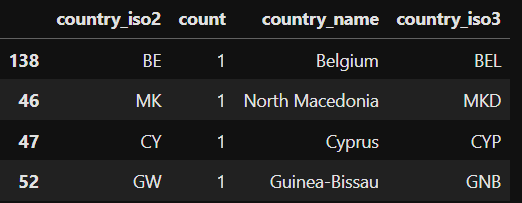

In [ ]:
from business import GraphBuilder
from plotly.graph_objects import Figure

gb = GraphBuilder()

# Does `GraphBuilder.build_nat_choropleth` return a Figure?
fig = gb.build_nat_choropleth()
assert isinstance(fig, Figure)
fig.show()

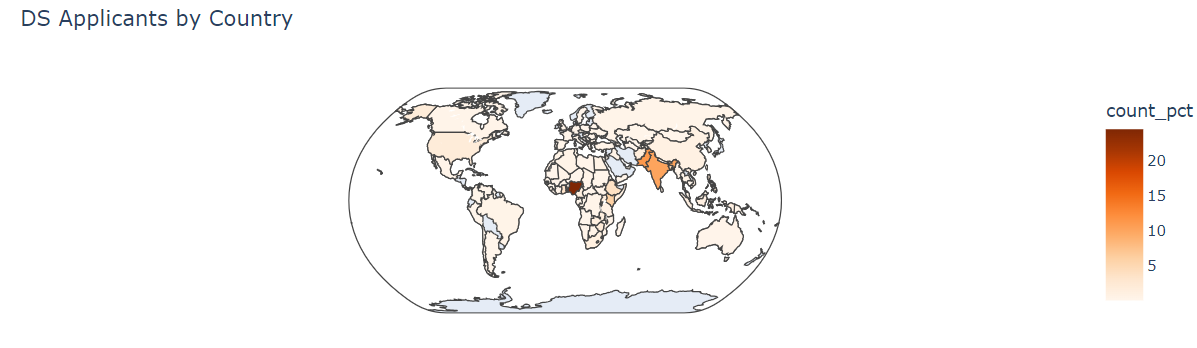

In [ ]:
import pandas as pd
from database import MongoRepository

repo = MongoRepository()
# Does `MongoRepository.get_ages` return a Series?
ages = repo.get_ages()
assert isinstance(ages, pd.Series)
ages.head()



```
0    26
1    25
2    30
3    40
4    34
Name: years, dtype: int64
```



In [ ]:
import pandas as pd
from database import MongoRepository

# Test  method
repo = MongoRepository()

# Does `MongoRepository.get_ed_value_counts` return a Series?
degrees = repo.get_ed_value_counts(normalize=False)
assert isinstance(degrees, pd.Series)

# Is Series index ordered correctly?
assert degrees.index.tolist() == [
    "High School or Baccalaureate",
    "Some College (1-3 years)",
    "Bachelor's degree",
    "Master's degree",
    "Doctorate (e.g. PhD)",
]

degrees



```
highest_degree_earned
High School or Baccalaureate     832
Some College (1-3 years)         612
Bachelor's degree               2643
Master's degree                  862
Doctorate (e.g. PhD)              76
Name: count, dtype: int64
```



In [ ]:
import pandas as pd
from database import MongoRepository

# Instantiate `MongoRepository`
repo = MongoRepository()

# Does `MongoRepository.get_no_quiz_per_day` return a Series?
no_quiz = repo.get_no_quiz_per_day()
assert isinstance(no_quiz, pd.Series)

# Does `MongoRepository.get_no_quiz_per_day` return correct value?
assert no_quiz.shape == (30,)

print("no_quiz shape:", no_quiz.shape)
print(no_quiz.head())



```
no_quiz shape: (30,)
date
2022-05-01    37
2022-05-02    49
2022-05-03    43
2022-05-04    48
2022-05-05    47
Name: new_users, dtype: int64
```



In [ ]:
import pandas as pd
from business import StatsBuilder
from database import MongoRepository

sb = StatsBuilder()
mr = MongoRepository()

# Does `MongoRepository.get_contingency_table` return a DataFrame?
sb.run_experiment(days=1)
contingency_tab = mr.get_contingency_table()
assert isinstance(contingency_tab, pd.DataFrame)

# Does `MongoRepository.get_contingency_table` return right shape?
assert contingency_tab.shape == (2, 2)
contingency_tab

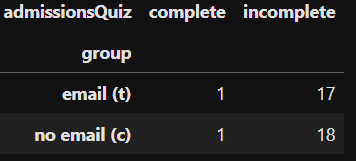

## business.py 👇

In [ ]:
import math

import numpy as np
import plotly.express as px
import scipy
from database import MongoRepository

from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
from teaching_tools.ab_test.experiment import Experiment


# Tasks 7.4.7, 7.4.9, 7.4.10, 7.4.19
class GraphBuilder:
    """Methods for building Graphs."""

    def __init__(self, repo=MongoRepository()):

        """init

        Parameters
        ----------
        repo : MongoRepository, optional
            Data source, by default MongoRepository()
        """
        self.repo = repo

    def build_nat_choropleth(self):

        """Creates nationality choropleth map.

        Returns
        -------
        Figure
        """
        # Get nationality counts from database
        df_nationality = self.repo.get_nationality_value_counts(normalize=True)
        # Create Figure
        fig = px.choropleth(
            data_frame=df_nationality,
            locations="country_iso3",
            color="count_pct",
            projection="natural earth",
            color_continuous_scale=px.colors.sequential.Oranges,
            title="DS Applicants by Country"
        )

        # Return Figure
        return fig

    def build_age_hist(self):

        """Create age histogram.

        Returns
        -------
        Figure
        """
        # Get ages from respository
        ages = self.repo.get_ages()
        # Create Figure
        fig = px.histogram(x=ages, nbins=20, title="Distribution of DS Applicant Ages")
        fig.update_layout(xaxis_title="Age",yaxis_title="Frequency [count]")
        # Return Figure
        return fig

    def build_ed_bar(self):

        """Creates education level bar chart.

        Returns
        -------
        Figure
        """
        # Get education level value counts from repo
        education = self.repo.get_ed_value_counts(normalize=True)
        # Create Figure
        fig = px.bar(
                x=education,
                y=education.index,
                orientation="h",
                title="DS Applicant Education Levels"
        )
        fig.update_layout(xaxis_title="Frequency [count]",yaxis_title="")
        # Return Figure
        return fig

    def build_contingency_bar(self):

        """Creates side-by-side bar chart from contingency table.

        Returns
        -------
        Figure
        """
        # Get contingency table data from repo
        data = self.repo.get_contingency_table()
        # Create Figure
        fig = px.bar(data_frame=data, barmode="group", title="Admissions Quiz Completion by Group")
        fig.update_layout(xaxis_title="Group", yaxis_title="Frequency [count]", legend={"title":"Admissions Quiz"})
        # Return Figure
        return fig


# Tasks 7.4.12, 7.4.18, 7.4.20
class StatsBuilder:
    """Methods for statistical analysis."""

    def __init__(self, repo=MongoRepository()):

        """init

        Parameters
        ----------
        repo : MongoRepository, optional
            Data source, by default MongoRepository()
        """
        self.repo = repo

    def calculate_n_obs(self, effect_size):

        """Calculate the number of observations needed to detect effect size.

        Parameters
        ----------
        effect_size : float
            Effect size you want to be able to detect

        Returns
        -------
        int
            Total number of observations needed, across two experimental groups.
        """
        # Calculate group size, w/ alpha=0.05 and power=0.8
        chi_square_power = GofChisquarePower()
        group_size = math.ceil(chi_square_power.solve_power(effect_size=effect_size, alpha=0.05, power=0.8))
        # Return number of observations (group size * 2)
        return (group_size*2)

    def calculate_cdf_pct(self, n_obs, days):

        """Calculate percent chance of gathering specified number of observations in
        specified number of days.

        Parameters
        ----------
        n_obs : int
            Number of observations you want to gather.
        days : int
            Number of days you will run experiment.

        Returns
        -------
        float
            Percentage chance of gathering ``n_obs`` or more in ``days``.
        """
        # Get data from repo
        no_quiz = self.repo.get_no_quiz_per_day()
        # Calculate quiz per day mean and std
        mean = no_quiz.mean()
        std = no_quiz.std()
        # Calculate mean and std for days
        days = 10
        sum_mean = mean * days
        sum_std = std * math.sqrt(days)
        # Calculate CDF probability, subtract from 1
        prob = 1 - scipy.stats.norm.cdf(n_obs, loc=sum_mean, scale=sum_std)
        # Turn probability to percentage
        pct = prob * 100
        # Return percentage
        return pct

    def run_experiment(self, days):

        """Run experiment. Add results to repository.

        Parameters
        ----------
        days : int
            Number of days to run experiment for.
        """
        # Instantiate Experiment
        exp = Experiment(repo=self.repo, db="wqu-abtest", collection="ds-applicants")
        # Reset experiment
        exp.reset_experiment()
        # Run Experiment
        result = exp.run_experiment(days=days)


    def run_chi_square(self):

        """Tests nominal association.

        Returns
        -------
        A bunch containing the following attributes:

        statistic: float
            The chi^2 test statistic.

        df: int
            The degrees of freedom of the reference distribution

        pvalue: float
            The p-value for the test.
        """
        # Get data from repo
        data = self.repo.get_contingency_table()
        # Create `Table2X2` from data
        contingency_table = Table2x2(data.values)
        # Run chi-square test
        chi_square_test = contingency_table.test_nominal_association()
        # Return chi-square results
        return chi_square_test

### Here we test if everything's working in the business layer

In [ ]:
from business import GraphBuilder
from plotly.graph_objects import Figure

gb = GraphBuilder()

# Does `GraphBuilder.build_nat_choropleth` return a Figure?
fig = gb.build_age_hist()
assert isinstance(fig, Figure)
fig.show()

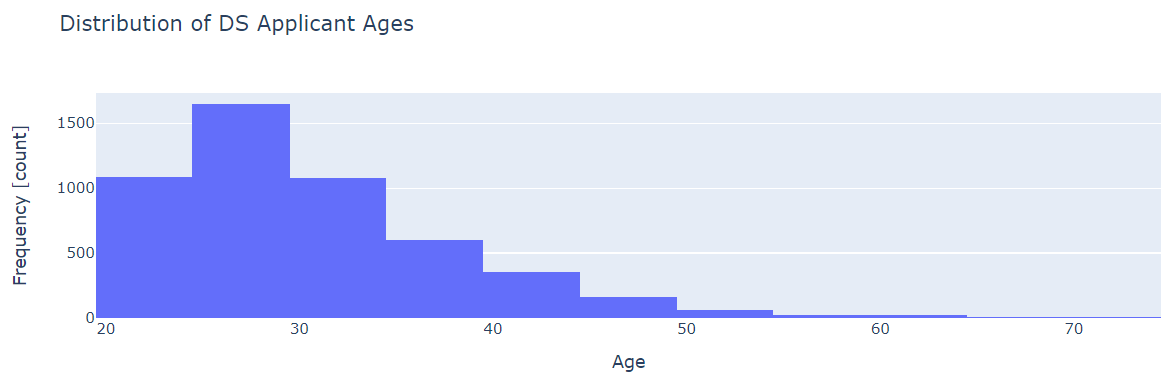

In [ ]:
from business import GraphBuilder
from plotly.graph_objects import Figure

gb = GraphBuilder()

# Does `GraphBuilder.build_ed_bar` return a Figure?
fig = gb.build_ed_bar()
assert isinstance(fig, Figure)
fig.show()

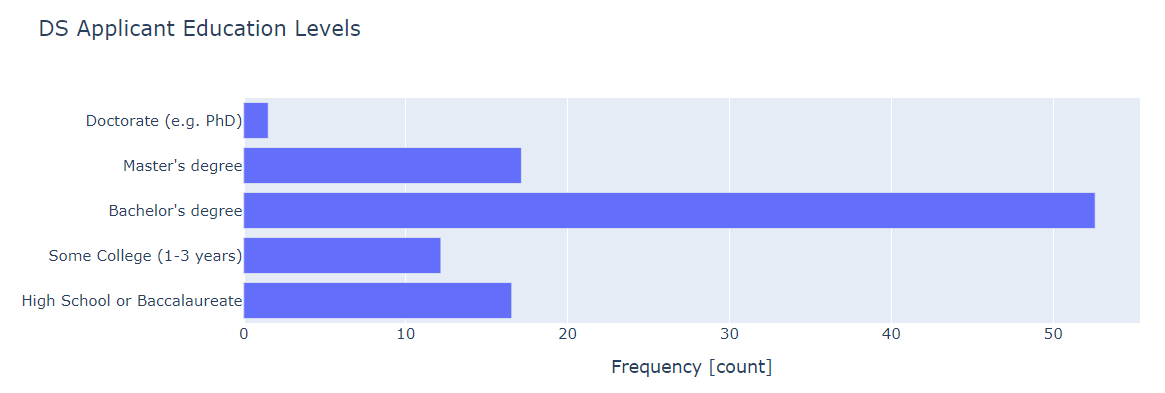

In [ ]:
from business import StatsBuilder
from database import MongoRepository

sb = StatsBuilder()

# Is `StatsBuilder.repo` the correct data type?
assert isinstance(sb.repo, MongoRepository)
sb.repo.collection.name

'ds-applicants'

In [ ]:
from business import StatsBuilder

# Does `StatsBuilder.calculate_n_obs` return an int?
n_obs = sb.calculate_n_obs(effect_size=0.2)
assert isinstance(n_obs, int)

# Does `StatsBuilder.calculate_n_obs` return correct number?
assert n_obs == 394
print("n observations for effect size of 0.2:", n_obs)

n observations for effect size of 0.2: 394

In [ ]:
from business import StatsBuilder

sb = StatsBuilder()

# Does `StatsBuilder.calculate_cdf_pct` return a float?
pct = sb.calculate_cdf_pct(n_obs=394, days=12)
assert isinstance(pct, float)

# Does `StatsBuilder.calculate_cdf_pct` return correct value
assert pct > 95
assert pct <= 100

print(f"Probability: {pct}%")

Probability: 98.10439590595297%

In [ ]:
from business import StatsBuilder
from database import MongoRepository
from teaching_tools.ab_test.experiment import Experiment

mr = MongoRepository()
exp = Experiment(repo=mr)
sb = StatsBuilder()
exp.reset_experiment()

# Does `StatsBuilder.run_experiment` add documents to database?
docs_before_exp = mr.collection.count_documents({})
sb.run_experiment(days=1)
docs_after_exp = mr.collection.count_documents({})
assert docs_after_exp > docs_before_exp

exp.reset_experiment()
print("Documents added to database:", docs_after_exp - docs_before_exp)

Documents added to database: 186

In [ ]:
from business import GraphBuilder, StatsBuilder
from plotly.graph_objects import Figure

gb = GraphBuilder()
sb = StatsBuilder()

# Does `GraphBuilder.build_contingency_bar` return a Figure?
sb.run_experiment(days=1)
fig = gb.build_contingency_bar()
assert isinstance(fig, Figure)
fig.show()

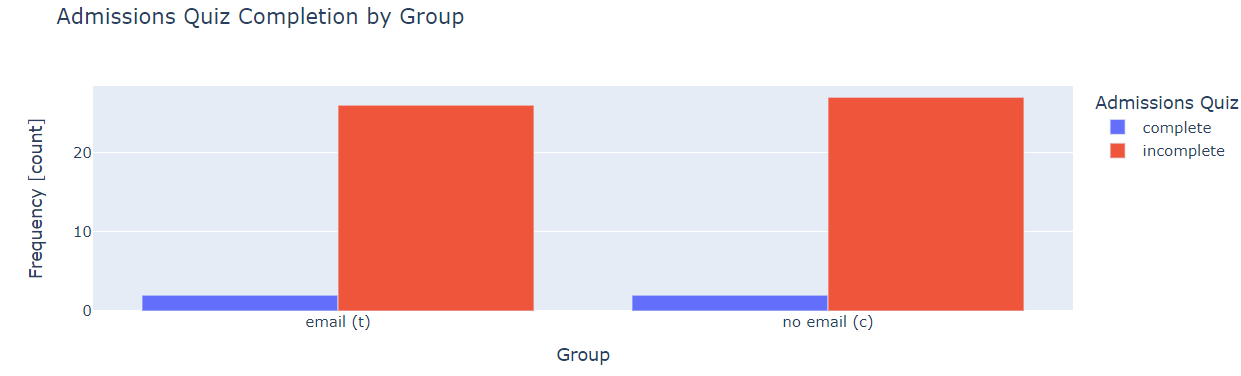




In [ ]:
from business import StatsBuilder
from statsmodels.stats.contingency_tables import _Bunch

sb = StatsBuilder()

# Does `StatsBuilder.run_chi_square` return a Bunch?
sb.run_experiment(days=1)
result = sb.run_chi_square()
assert isinstance(result, _Bunch)

# Is Bunch p-value correct?
p_val = result.pvalue
assert p_val > 0.05

print("Experiment p-value:", p_val)

Experiment p-value: 0.9942620367782493

Look at Dash2.mp4